### Import Libraries

In [ ]:
!pip install -U setuptools pip
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2 -y
!pip install -U tensorflow==2.11.0
!pip install numpy --upgrade --ignore-installed

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn as skl
import skimage as ski
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

from tensorflow.keras.applications import convnext


### Set seed for reproducibility

In [3]:
# Random seed for reproducibility
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Dataset

In [4]:
dataset_dir = '/kaggle/input/dataset2-dup/training_data_split_duplicate'
dataset_dir_train = dataset_dir + '/training'
dataset_dir_valid = dataset_dir + '/validation'

In [5]:
# Labels
labels = {0: 'Species1',       # 0
          1: 'Species2',       # 1
          2: 'Species3',       # 2
          3: 'Species4',       # 3
          4: 'Species5',       # 4
          5: 'Species6',       # 5
          6: 'Species7',       # 6
          7: 'Species8',       # 7
         }

In [6]:
# Create an instance of ImageDataGenerator WITH Data Augmentation for training set
train_data_gen = ImageDataGenerator(brightness_range=[0.5, 1.2],
                                        channel_shift_range=50,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        rotation_range=90,
                                        width_shift_range=50,
                                        height_shift_range=50,
                                        zoom_range = 0.1,
                                        fill_mode='reflect')

# Create an instance of ImageDataGenerator WITHOUT Data Augmentation for validation set
valid_data_gen = ImageDataGenerator()


train_gen = train_data_gen.flow_from_directory(directory=dataset_dir_train,
                                              target_size=(96,96),
                                              color_mode='rgb',
                                              classes=None,
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=dataset_dir_valid,
                                              target_size=(96,96),
                                              color_mode='rgb',
                                              classes=None,
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=False,
                                              seed=seed)

Found 3727 images belonging to 8 classes.
Found 351 images belonging to 8 classes.


In [7]:
# Numpy arrays for dataset

train_gen.reset()
X_train = np.concatenate([train_gen.next()[0] for i in range(train_gen.__len__())])
y_train = np.concatenate([train_gen.next()[1] for i in range(train_gen.__len__())])
print(X_train.shape)
print(y_train.shape)

valid_gen.reset()
X_val = np.concatenate([valid_gen.next()[0] for i in range(valid_gen.__len__())])
y_val = np.concatenate([valid_gen.next()[1] for i in range(valid_gen.__len__())])
print(X_val.shape)
print(y_val.shape)

(3727, 96, 96, 3)
(3727, 8)
(351, 96, 96, 3)
(351, 8)


### Model metadata

In [8]:
input_shape = (96,96,3)
batch_size = 16
epochs = 200
l2_lambda = 2e-5

# Transfer learning

In [ ]:
base_model = convnext.ConvNeXtBase(
    include_top=False,
    weights='imagenet',
    input_shape=(96,96,3)
    );

In [10]:
def build_model():
    tf.random.set_seed(seed)
    base_model.trainable=False

    x = base_model.output
    
    x = tfkl.GlobalAveragePooling2D(name='GlobalAveragePooling')(x)
    
    x = tfkl.Dropout(rate=0.3, seed=seed, name='Dropout1')(x)
    
    x = tfkl.Dense(
            units = 256,
            activation = 'sigmoid',
            kernel_initializer = tfk.initializers.HeUniform(seed),
            kernel_regularizer = tf.keras.regularizers.l2(l2_lambda),
            name = 'Dense'
            )(x)
    
    x = tfkl.Dropout(rate=0.4, seed=seed, name='Dropout2')(x)
    
    output_layer = tfkl.Dense(
        units = 8, 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'Output'
    )(x)

    model = tfk.Model(inputs=base_model.input, outputs=output_layer, name='model')
    
    model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                  optimizer=tfk.optimizers.Adam(learning_rate=1e-4), 
                  metrics='accuracy')
    
    return model

In [11]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 convnext_base_prestem_normaliz  (None, 96, 96, 3)   0           ['input_1[0][0]']                
 ation (Normalization)                                                                            
                                                                                                  
 convnext_base_stem (Sequential  (None, 24, 24, 128)  6528       ['convnext_base_prestem_normaliza
 )                                                               tion[0][0]']                     
                                                                                              

In [12]:
# Train the model
history = model.fit(
    x = train_gen,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)],
).history

Epoch 1/200


2022-11-24 18:44:45.330171: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-11-24 18:44:46.875039: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-11-24 18:44:46.942577: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-addr

  1/233 [..............................] - ETA: 1:38:20 - loss: 2.2608 - accuracy: 0.0625

2022-11-24 18:44:49.866539: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


144/233 [=================>............] - ETA: 10s - loss: 2.1261 - accuracy: 0.1879

2022-11-24 18:45:07.091729: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-11-24 18:45:07.375197: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-11-24 18:45:07.665569: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-addr

145/233 [=================>............] - ETA: 11s - loss: 2.1257 - accuracy: 0.1880

2022-11-24 18:45:09.098153: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


233/233 [==============================] - 66s 173ms/step - loss: 2.0129 - accuracy: 0.2380 - val_loss: 1.5519 - val_accuracy: 0.4929
Epoch 2/200
233/233 [==============================] - 31s 130ms/step - loss: 1.6307 - accuracy: 0.3939 - val_loss: 1.3090 - val_accuracy: 0.5983
Epoch 3/200
233/233 [==============================] - 30s 129ms/step - loss: 1.4844 - accuracy: 0.4615 - val_loss: 1.1643 - val_accuracy: 0.6182
Epoch 4/200
233/233 [==============================] - 31s 133ms/step - loss: 1.3701 - accuracy: 0.5031 - val_loss: 1.0896 - val_accuracy: 0.6296
Epoch 5/200
233/233 [==============================] - 31s 133ms/step - loss: 1.3046 - accuracy: 0.5390 - val_loss: 1.0072 - val_accuracy: 0.6496
Epoch 6/200
233/233 [==============================] - 31s 133ms/step - loss: 1.2361 - accuracy: 0.5474 - val_loss: 0.9528 - val_accuracy: 0.6610
Epoch 7/200
233/233 [==============================] - 31s 133ms/step - loss: 1.2076 - accuracy: 0.5777 - val_loss: 0.9248 - val_accurac

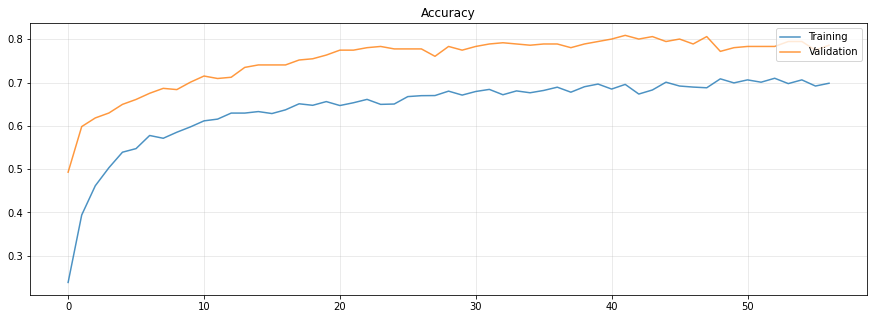

In [13]:
plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation', alpha=.8)
plt.title('Accuracy')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

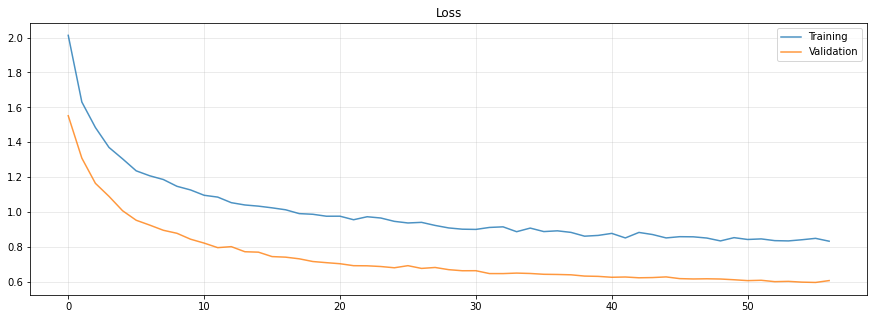

In [14]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8)
plt.plot(history['val_loss'], label='Validation', alpha=.8)
plt.title('Loss')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

### Save the model

In [15]:
# Save the best model
model.save('ConvNextBase_tl')
del model

# Fine Tuning

In [16]:
# Re-load the model after transfer learning
model = tfk.models.load_model('ConvNextBase_tl')
#model.summary()

In [17]:
# Set all layers to True
for layer in model.layers:
    layer.trainable = True

In [18]:
model.compile(loss=tfk.losses.CategoricalCrossentropy(), 
              optimizer=tfk.optimizers.Adam(learning_rate=1e-5),
              metrics='accuracy')

In [19]:
# Fine-tune the model
history = model.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)]
).history

Epoch 1/200


2022-11-24 19:16:30.367438: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-11-24 19:16:30.867870: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-11-24 19:16:31.868777: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-addr

 81/233 [=========>....................] - ETA: 36s - loss: 0.8349 - accuracy: 0.6975

2022-11-24 19:17:25.473478: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-11-24 19:17:26.088014: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-11-24 19:17:29.052297: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-addr

233/233 [==============================] - 151s 317ms/step - loss: 0.7606 - accuracy: 0.7312 - val_loss: 0.5198 - val_accuracy: 0.8177
Epoch 2/200
233/233 [==============================] - 59s 254ms/step - loss: 0.6517 - accuracy: 0.7752 - val_loss: 0.4831 - val_accuracy: 0.8205
Epoch 3/200
233/233 [==============================] - 60s 256ms/step - loss: 0.5861 - accuracy: 0.7937 - val_loss: 0.4707 - val_accuracy: 0.8319
Epoch 4/200
233/233 [==============================] - 60s 255ms/step - loss: 0.5346 - accuracy: 0.8090 - val_loss: 0.4504 - val_accuracy: 0.8405
Epoch 5/200
233/233 [==============================] - 60s 259ms/step - loss: 0.4775 - accuracy: 0.8377 - val_loss: 0.4365 - val_accuracy: 0.8490
Epoch 6/200
233/233 [==============================] - 60s 255ms/step - loss: 0.4489 - accuracy: 0.8492 - val_loss: 0.4233 - val_accuracy: 0.8718
Epoch 7/200
233/233 [==============================] - 59s 254ms/step - loss: 0.4375 - accuracy: 0.8492 - val_loss: 0.4326 - val_accura

### Plot Results

In [20]:
print(f"Max Training accuracy: {max(history['accuracy'])}")
print(f"Max Validation accuracy: {max(history['val_accuracy'])}")

Max Training accuracy: 0.9790716171264648
Max Validation accuracy: 0.9430199265480042


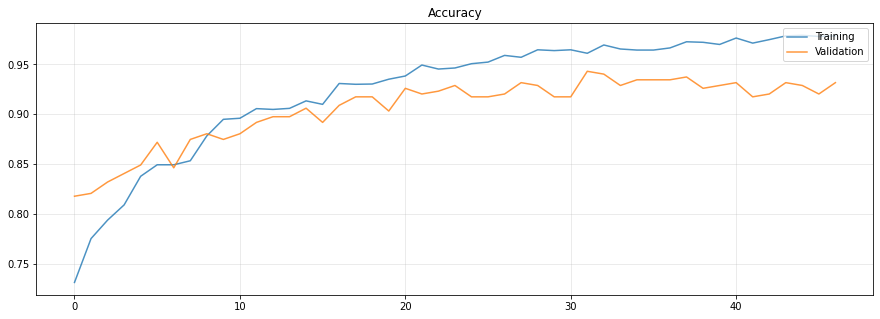

In [21]:
plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation', alpha=.8)
plt.title('Accuracy')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

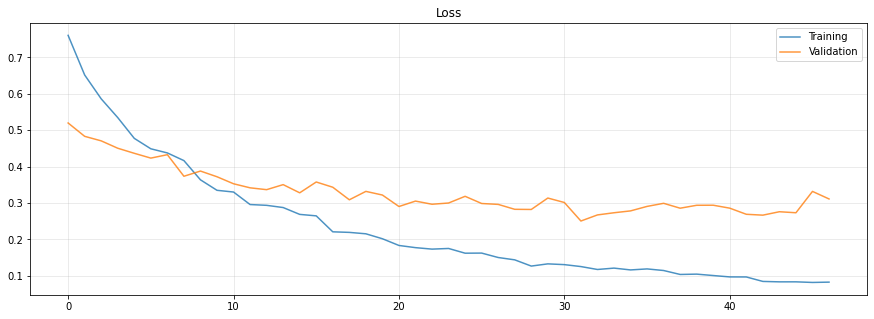

In [22]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8)
plt.plot(history['val_loss'], label='Validation', alpha=.8)
plt.title('Loss')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

### Confusion Matrix

2022-11-24 20:05:48.976891: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-11-24 20:05:49.320433: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-11-24 20:05:49.646505: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-addr

 1/11 [=>............................] - ETA: 58s

2022-11-24 20:05:51.071258: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


10/11 [==========================>...] - ETA: 0s

2022-11-24 20:05:52.437124: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-11-24 20:05:52.719444: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-11-24 20:05:53.006784: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-addr

11/11 [==============================] - 9s 353ms/step


2022-11-24 20:05:54.601143: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


Accuracy: 0.943
Precision: 0.9454
Recall: 0.9211
F1: 0.9304


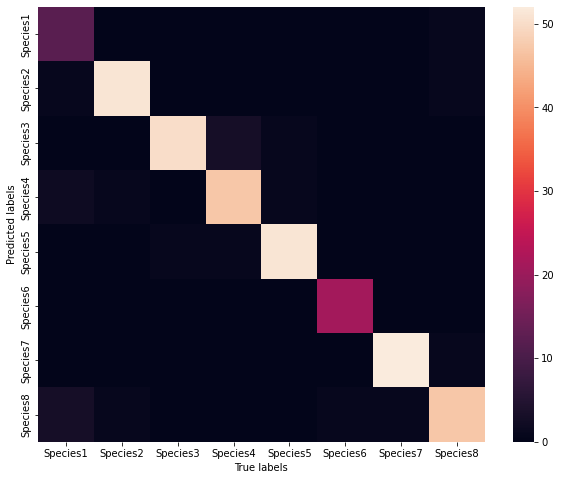

In [23]:
# Predict the test set with the CNN
predictions = model.predict(X_val)
predictions.shape

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [24]:
# Get the classification report
print(classification_report(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1)))

              precision    recall  f1-score   support

           0       0.92      0.67      0.77        18
           1       0.96      0.96      0.96        53
           2       0.93      0.98      0.95        51
           3       0.92      0.92      0.92        51
           4       0.96      0.96      0.96        53
           5       1.00      0.95      0.98        22
           6       0.98      0.98      0.98        53
           7       0.89      0.94      0.91        50

    accuracy                           0.94       351
   macro avg       0.95      0.92      0.93       351
weighted avg       0.94      0.94      0.94       351



### Save the model

In [25]:
model.save('ConvNextBase_ft', include_optimizer=False)